In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Flatten 
from tensorflow.keras.layers import Add, Concatenate, Lambda, Input, Permute
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score



In [2]:
def draw_learning_curves(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path):
    # Generate confusion matrix plot
    display_labels = ['Left hand', 'Right hand','Foot','Tongue']
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

In [3]:
def load_data(data_path, subject, training, all_trials = False):
    # Define MI-trials parameters
    n_channels = 22
    n_tests = 6*48 	
    window_Length = 7*250 

    class_return = np.zeros(n_tests)
    data_return = np.zeros((n_tests, n_channels, window_Length))

    NO_valid_trial = 0
    if training:
        a = sio.loadmat(data_path+'A0'+str(subject)+'T.mat')
    else:
        a = sio.loadmat(data_path+'A0'+str(subject)+'E.mat')
    a_data = a['data']
    for ii in range(0,a_data.size):
        a_data1 = a_data[0,ii]
        a_data2= [a_data1[0,0]]
        a_data3= a_data2[0]
        a_X = a_data3[0]
        a_trial = a_data3[1]
        a_y = a_data3[2]
        a_artifacts = a_data3[5]

        for trial in range(0,a_trial.size):
            if(a_artifacts[trial] != 0 and not all_trials):
                continue
            data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+window_Length),:22])
            class_return[NO_valid_trial] = int(a_y[trial])
            NO_valid_trial +=1


    return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]

def standardize_data(X_train, X_test, channels): 
    for j in range(channels):
          scaler = StandardScaler()
          scaler.fit(X_train[:, 0, j, :])
          X_train[:, 0, j, :] = scaler.transform(X_train[:, 0, j, :])
          X_test[:, 0, j, :] = scaler.transform(X_test[:, 0, j, :])

    return X_train, X_test

def get_data(path, subject, isStandard = True):
    # Define dataset parameters
    fs = 250          # sampling rate
    t1 = int(1.5*fs)  # start time_point
    t2 = int(6*fs)    # end time_point
    T = t2-t1         # length of the MI trial (samples or time_points)
    
    # Loading and Dividing of the data set based on the subject-specific 
    # (subject-dependent) approach.In this approach, we used the same 
    # training and testing data as the original competition, i.e., trials 
    # in session 1 for training, and trials in session 2 for testing.  
    path = path + 's{:}/'.format(subject+1)
    X_train, y_train = load_data(path, subject+1, True)
    X_test, y_test = load_data(path, subject+1, False)

    # Prepare training data 
    N_tr, N_ch, _ = X_train.shape 
    X_train = X_train[:, :, t1:t2].reshape(N_tr, 1, N_ch, T)
    y_train_onehot = (y_train-1).astype(int)
    y_train_onehot = to_categorical(y_train_onehot)
    # Prepare testing data 
    N_test, N_ch, _ = X_test.shape 
    X_test = X_test[:, :, t1:t2].reshape(N_test, 1, N_ch, T)
    y_test_onehot = (y_test-1).astype(int)
    y_test_onehot = to_categorical(y_test_onehot)
    
    # Standardize the data
    if (isStandard == True):
        X_train, X_test = standardize_data(X_train, X_test, N_ch)

    return X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot

In [4]:
def ML_Model(n_classes=4, in_chans = 22, in_samples = 1125, n_windows = 5, attention = None, 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 8, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average'):
   
    input_1 = Input(shape = (1,in_chans, in_samples))   #     TensorShape([None, 1, 22, 1125])
    input_2 = Permute((3,2,1))(input_1) 
    regRate=.25
    numFilters = eegn_F1
    F2 = numFilters*eegn_D

    block1 = Conv_block(input_layer = input_2, F1 = eegn_F1, D = eegn_D, 
                        kernLength = eegn_kernelSize, poolSize = eegn_poolSize,
                        in_chans = in_chans, dropout = eegn_dropout)
    block1 = Lambda(lambda x: x[:,:,-1,:])(block1)
     
    # Sliding window 
    sw_concat = []   # to store concatenated or averaged sliding window outputs
    for i in range(n_windows):
        st = i
        end = block1.shape[1]-n_windows+i+1
        block2 = block1[:, st:end, :]
        
        # Attention_model
        if attention is not None:
            block2 = attention_block(block2, attention)

        # Temporal convolutional network (TCN)
        block3 = TCN_block(input_layer = block2, input_dimension = F2, depth = tcn_depth,
                            kernel_size = tcn_kernelSize, filters = tcn_filters, 
                            dropout = tcn_dropout, activation = tcn_activation)
        # Get feature maps of the last sequence
        block3 = Lambda(lambda x: x[:,-1,:])(block3)
        
        # Outputs of sliding window: Average_after_dense or concatenate_then_dense
        if(fuse == 'average'):
            sw_concat.append(Dense(n_classes, kernel_constraint = max_norm(regRate))(block3))
        elif(fuse == 'concat'):
            if i == 0:
                sw_concat = block3
            else:
                sw_concat = Concatenate()([sw_concat, block3])
                
    if(fuse == 'average'):
        if len(sw_concat) > 1: # more than one window
            sw_concat = tf.keras.layers.Average()(sw_concat[:])
        else: # one window (# windows = 1)
            sw_concat = sw_concat[0]
    elif(fuse == 'concat'):
        sw_concat = Dense(n_classes, kernel_constraint = max_norm(regRate))(sw_concat)
            
    
    softmax = Activation('softmax', name = 'softmax')(sw_concat)
    
    return Model(inputs = input_1, outputs = softmax)

#Convolutional (CV) block
def Conv_block(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=22, dropout=0.1):

    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, in_chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3


def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='relu'):
    
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

In [8]:
def train(dataset_conf, train_conf, results_path):
    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")
    # Create a .npz file to store the accuracy and kappa metrics 
    perf_allRuns = open(results_path + "/perf_allRuns.npz", 'wb')
    
    # Get dataset paramters
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))
    
    # Iteration over subjects 
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Get the current 'IN' time to calculate the subject training time
        in_sub = time.time()
        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0 
        bestTrainingHistory = [] 
        # Get training and test data
        X_train, _, y_train_onehot, X_test, _, y_test_onehot = get_data(
            data_path, sub, isStandard)
        
        # Iteration over multiple runs 
        for train in range(n_train): # How many repetitions of training for subject i.
            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()
            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)        
            filepath = filepath + '/subject-{}.h5'.format(sub+1)
            # Create the model
            model = ML_Model()
            # Compile and train the model
            model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])          
            callbacks = [
                ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, 
                                save_best_only=True, save_weights_only=True, mode='max'),
                EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), 
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=2)
            # Evaluate the performance of the trained model. 
            # Here we load the Trained weights from the file saved in the hard 
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_test).argmax(axis=-1)
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)
              
            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   Train no. {}   Time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'Test_acc: {:.4f}   Test_kappa: {:.4f}'.format(acc[sub, train], kappa[sub, train])
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history
        
        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)
        # Get the current 'OUT' time to calculate the subject training time
        out_sub = time.time()
        # Print & write the best subject performance among multiple runs
        info = '----------\n'
        info = info + 'Subject: {}   best_run: {}   Time: {:.1f} m   '.format(sub+1, best_run+1, ((out_sub-in_sub)/60))
        info = info + 'acc: {:.4f}   avg_acc: {:.4f} +- {:.4f}   '.format(acc[sub, best_run], np.average(acc[sub, :]), acc[sub,:].std() )
        info = info + 'kappa: {:.4f}   avg_kappa: {:.4f} +- {:.4f}'.format(kappa[sub, best_run], np.average(kappa[sub, :]), kappa[sub,:].std())
        info = info + '\n----------'
        print(info)
        log_write.write(info+'\n')
        # Plot Learning curves 
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory)
          
    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()
    info = '\nTime: {:.1f} h   '.format( (out_exp-in_exp)/(60*60) )
    print(info)
    log_write.write(info+'\n')
    
    # Store the accuracy and kappa metrics as arrays for all runs into a .npz 
    # file format, which is an uncompressed zipped archive, to calculate average
    # accuracy/kappa over all runs.
    np.savez(perf_allRuns, acc = acc, kappa = kappa)
    
    # Close open files 
    best_models.close()   
    log_write.close() 
    perf_allRuns.close() 

In [21]:
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results 
    
    log_write = open(str(results_path) + "/log.txt", "a")
    # Open the file that stores the path of the best models among several random runs.
    best_models = open(results_path + "/best models.txt", "r")   
    
    # Get dataset paramters
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    
    # Initialize variables
    acc_bestRun = np.zeros(n_sub)
    kappa_bestRun = np.zeros(n_sub)  
    cf_matrix = np.zeros([n_sub, n_classes, n_classes])

    # Calculate the average performance (average accuracy and K-score) for 
    # all runs (experiments) for each subject.
    if(allRuns): 
        # Load the test accuracy and kappa metrics as arrays for all runs from a .npz 
        # file format, which is an uncompressed zipped archive, to calculate average
        # accuracy/kappa over all runs.
        perf_allRuns = open(results_path + "/perf_allRuns.npz", 'rb')
        perf_arrays = np.load(perf_allRuns)
        acc_allRuns = perf_arrays['acc']
        kappa_allRuns = perf_arrays['kappa']
    
    # Iteration over subjects 
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, isStandard)
        # Load the best model out of multiple random runs (experiments).
        filepath = best_models.readline()
        model.load_weights(results_path + filepath[:-1])
        # Predict MI task
        y_pred = model.predict(X_test).argmax(axis=-1)
        # Calculate accuracy and K-score
        labels = y_test_onehot.argmax(axis=-1)
        acc_bestRun[sub] = accuracy_score(labels, y_pred)
        kappa_bestRun[sub] = cohen_kappa_score(labels, y_pred)
        # Calculate and draw confusion matrix
        cf_matrix[sub, :, :] = confusion_matrix(labels, y_pred, normalize='pred')
        draw_confusion_matrix(cf_matrix[sub, :, :], str(sub+1), results_path)
        
        # Print & write performance measures for each subject
        info = 'Subject: {}   best_run: {:2}  '.format(sub+1, (filepath[filepath.find('run-')+4:filepath.find('/sub')]) )
        info = info + 'acc: {:.4f}   kappa: {:.4f}   '.format(acc_bestRun[sub], kappa_bestRun[sub] )
        if(allRuns): 
            info = info + 'avg_acc: {:.4f} +- {:.4f}   avg_kappa: {:.4f} +- {:.4f}'.format(
                np.average(acc_allRuns[sub, :]), acc_allRuns[sub,:].std(),
                np.average(kappa_allRuns[sub, :]), kappa_allRuns[sub,:].std() )
        print(info)
        log_write.write('\n'+info)
      
    # Print & write the average performance measures for all subjects     
    info = '\nAverage of {} subjects - best runs:\nAccuracy = {:.4f}   Kappa = {:.4f}\n'.format(
        n_sub, np.average(acc_bestRun), np.average(kappa_bestRun)) 
    if(allRuns): 
        info = info + '\nAverage of {} subjects x {} runs (average of {} experiments):\nAccuracy = {:.4f}   Kappa = {:.4f}'.format(
            n_sub, acc_allRuns.shape[1], (n_sub * acc_allRuns.shape[1]),
            np.average(acc_allRuns), np.average(kappa_allRuns)) 
    print(info)
    log_write.write(info)
    
    # Draw a performance bar chart for all subjects 
    draw_performance_barChart(n_sub, acc_bestRun, 'Accuracy')
    draw_performance_barChart(n_sub, kappa_bestRun, 'K-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean(0), 'All', results_path)
    # Close open files     
    log_write.close() 
    


Training on subject  1
Epoch 1/250
5/5 - 23s - loss: 1.5288 - accuracy: 0.2015 - val_loss: 1.3282 - val_accuracy: 0.3950 - 23s/epoch - 5s/step
Epoch 2/250
5/5 - 4s - loss: 1.3312 - accuracy: 0.3663 - val_loss: 1.2974 - val_accuracy: 0.4128 - 4s/epoch - 737ms/step
Epoch 3/250
5/5 - 4s - loss: 1.2303 - accuracy: 0.4689 - val_loss: 1.4092 - val_accuracy: 0.4021 - 4s/epoch - 704ms/step
Epoch 4/250
5/5 - 4s - loss: 1.1457 - accuracy: 0.5275 - val_loss: 1.5036 - val_accuracy: 0.4093 - 4s/epoch - 750ms/step
Epoch 5/250
5/5 - 3s - loss: 1.0633 - accuracy: 0.5788 - val_loss: 1.4611 - val_accuracy: 0.4555 - 3s/epoch - 692ms/step
Epoch 6/250
5/5 - 3s - loss: 1.0345 - accuracy: 0.5861 - val_loss: 1.4519 - val_accuracy: 0.4804 - 3s/epoch - 682ms/step
Epoch 7/250
5/5 - 3s - loss: 0.9199 - accuracy: 0.6667 - val_loss: 1.7749 - val_accuracy: 0.4413 - 3s/epoch - 639ms/step
Epoch 8/250
5/5 - 4s - loss: 0.8726 - accuracy: 0.7070 - val_loss: 1.4409 - val_accuracy: 0.4875 - 4s/epoch - 749ms/step
Epoch 9/2

5/5 - 3s - loss: 0.0996 - accuracy: 0.9890 - val_loss: 1.2475 - val_accuracy: 0.6370 - 3s/epoch - 648ms/step
Epoch 69/250
5/5 - 4s - loss: 0.1022 - accuracy: 0.9707 - val_loss: 1.0121 - val_accuracy: 0.7117 - 4s/epoch - 793ms/step
Epoch 70/250
5/5 - 4s - loss: 0.0927 - accuracy: 0.9817 - val_loss: 1.1953 - val_accuracy: 0.7046 - 4s/epoch - 707ms/step
Epoch 71/250
5/5 - 3s - loss: 0.1002 - accuracy: 0.9707 - val_loss: 1.4014 - val_accuracy: 0.6868 - 3s/epoch - 644ms/step
Epoch 72/250
5/5 - 2s - loss: 0.1278 - accuracy: 0.9707 - val_loss: 1.3669 - val_accuracy: 0.6868 - 2s/epoch - 480ms/step
Epoch 73/250
5/5 - 2s - loss: 0.0963 - accuracy: 0.9853 - val_loss: 1.1822 - val_accuracy: 0.6690 - 2s/epoch - 466ms/step
Epoch 74/250
5/5 - 2s - loss: 0.1000 - accuracy: 0.9780 - val_loss: 1.4497 - val_accuracy: 0.6690 - 2s/epoch - 488ms/step
Epoch 75/250
5/5 - 2s - loss: 0.1090 - accuracy: 0.9707 - val_loss: 1.1499 - val_accuracy: 0.7224 - 2s/epoch - 465ms/step
Epoch 76/250
5/5 - 2s - loss: 0.0959 

Epoch 135/250
5/5 - 2s - loss: 0.0235 - accuracy: 0.9963 - val_loss: 0.7201 - val_accuracy: 0.7865 - 2s/epoch - 490ms/step
Epoch 136/250
5/5 - 2s - loss: 0.0172 - accuracy: 0.9963 - val_loss: 0.6338 - val_accuracy: 0.8007 - 2s/epoch - 464ms/step
Epoch 137/250
5/5 - 2s - loss: 0.0308 - accuracy: 0.9890 - val_loss: 0.6883 - val_accuracy: 0.7900 - 2s/epoch - 447ms/step
Epoch 138/250
5/5 - 2s - loss: 0.0319 - accuracy: 0.9890 - val_loss: 0.7100 - val_accuracy: 0.7829 - 2s/epoch - 486ms/step
Epoch 139/250
5/5 - 3s - loss: 0.0557 - accuracy: 0.9853 - val_loss: 0.7080 - val_accuracy: 0.8043 - 3s/epoch - 541ms/step
Epoch 140/250
5/5 - 2s - loss: 0.0311 - accuracy: 0.9963 - val_loss: 1.0456 - val_accuracy: 0.7331 - 2s/epoch - 480ms/step
Epoch 141/250
5/5 - 2s - loss: 0.0352 - accuracy: 0.9927 - val_loss: 0.9756 - val_accuracy: 0.7402 - 2s/epoch - 486ms/step
Epoch 142/250
5/5 - 2s - loss: 0.0408 - accuracy: 0.9890 - val_loss: 0.8439 - val_accuracy: 0.7402 - 2s/epoch - 469ms/step
Epoch 143/250
5/

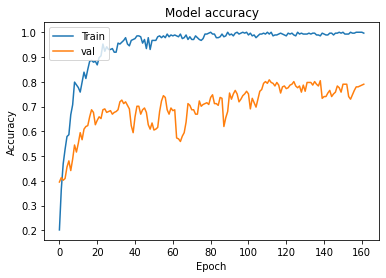

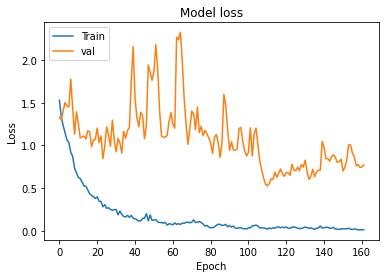


Training on subject  2
Epoch 1/250
5/5 - 12s - loss: 1.5126 - accuracy: 0.2926 - val_loss: 1.3340 - val_accuracy: 0.3534 - 12s/epoch - 2s/step
Epoch 2/250
5/5 - 2s - loss: 1.3176 - accuracy: 0.3889 - val_loss: 1.3584 - val_accuracy: 0.3604 - 2s/epoch - 465ms/step
Epoch 3/250
5/5 - 2s - loss: 1.2081 - accuracy: 0.5000 - val_loss: 1.4686 - val_accuracy: 0.3604 - 2s/epoch - 474ms/step
Epoch 4/250
5/5 - 3s - loss: 1.1427 - accuracy: 0.5259 - val_loss: 1.5640 - val_accuracy: 0.3922 - 3s/epoch - 521ms/step
Epoch 5/250
5/5 - 2s - loss: 1.0916 - accuracy: 0.5593 - val_loss: 1.5371 - val_accuracy: 0.4099 - 2s/epoch - 483ms/step
Epoch 6/250
5/5 - 2s - loss: 1.0712 - accuracy: 0.5407 - val_loss: 1.6099 - val_accuracy: 0.4205 - 2s/epoch - 484ms/step
Epoch 7/250
5/5 - 2s - loss: 1.0070 - accuracy: 0.5741 - val_loss: 1.5291 - val_accuracy: 0.4382 - 2s/epoch - 493ms/step
Epoch 8/250
5/5 - 2s - loss: 0.9239 - accuracy: 0.6556 - val_loss: 1.3783 - val_accuracy: 0.4770 - 2s/epoch - 485ms/step
Epoch 9/2

5/5 - 2s - loss: 0.0636 - accuracy: 0.9963 - val_loss: 1.7910 - val_accuracy: 0.5406 - 2s/epoch - 490ms/step
Epoch 69/250
5/5 - 3s - loss: 0.0659 - accuracy: 0.9926 - val_loss: 1.7256 - val_accuracy: 0.5442 - 3s/epoch - 545ms/step
Epoch 70/250
5/5 - 2s - loss: 0.0691 - accuracy: 0.9963 - val_loss: 1.8623 - val_accuracy: 0.5159 - 2s/epoch - 495ms/step
Epoch 71/250
5/5 - 2s - loss: 0.0837 - accuracy: 0.9815 - val_loss: 1.8885 - val_accuracy: 0.4982 - 2s/epoch - 496ms/step
Epoch 72/250
5/5 - 2s - loss: 0.0748 - accuracy: 0.9963 - val_loss: 1.7649 - val_accuracy: 0.5124 - 2s/epoch - 477ms/step
Epoch 73/250
5/5 - 2s - loss: 0.0745 - accuracy: 0.9926 - val_loss: 1.7306 - val_accuracy: 0.5230 - 2s/epoch - 455ms/step
Epoch 74/250
5/5 - 2s - loss: 0.0984 - accuracy: 0.9852 - val_loss: 1.8598 - val_accuracy: 0.5336 - 2s/epoch - 474ms/step
Epoch 75/250
5/5 - 2s - loss: 0.0845 - accuracy: 0.9815 - val_loss: 1.8024 - val_accuracy: 0.5230 - 2s/epoch - 457ms/step
Epoch 76/250
5/5 - 2s - loss: 0.0571 

Epoch 135/250
5/5 - 3s - loss: 0.0227 - accuracy: 0.9963 - val_loss: 1.9628 - val_accuracy: 0.5018 - 3s/epoch - 508ms/step
Epoch 136/250
5/5 - 2s - loss: 0.0383 - accuracy: 0.9926 - val_loss: 1.8895 - val_accuracy: 0.5124 - 2s/epoch - 481ms/step
Epoch 136: early stopping
9/9 [==============================] - 1s 65ms/step
Subject: 2   Train no. 1   Time: 5.8 m   Test_acc: 0.5654   Test_kappa: 0.4207
----------
Subject: 2   best_run: 1   Time: 5.8 m   acc: 0.5654   avg_acc: 0.5654 +- 0.0000   kappa: 0.4207   avg_kappa: 0.4207 +- 0.0000
----------
Plot Learning Curves ....... 


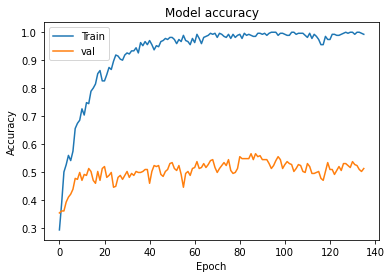

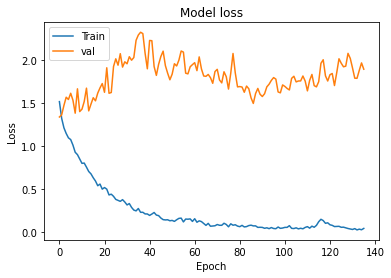


Training on subject  3
Epoch 1/250
5/5 - 12s - loss: 1.4427 - accuracy: 0.3296 - val_loss: 1.3269 - val_accuracy: 0.4212 - 12s/epoch - 2s/step
Epoch 2/250
5/5 - 2s - loss: 1.2842 - accuracy: 0.4111 - val_loss: 1.2520 - val_accuracy: 0.4396 - 2s/epoch - 472ms/step
Epoch 3/250
5/5 - 2s - loss: 1.1654 - accuracy: 0.5407 - val_loss: 1.5202 - val_accuracy: 0.3773 - 2s/epoch - 439ms/step
Epoch 4/250
5/5 - 2s - loss: 1.0784 - accuracy: 0.5889 - val_loss: 2.2906 - val_accuracy: 0.3187 - 2s/epoch - 459ms/step
Epoch 5/250
5/5 - 2s - loss: 0.9819 - accuracy: 0.6444 - val_loss: 2.9345 - val_accuracy: 0.3150 - 2s/epoch - 475ms/step
Epoch 6/250
5/5 - 3s - loss: 0.9005 - accuracy: 0.6444 - val_loss: 2.9830 - val_accuracy: 0.3590 - 3s/epoch - 535ms/step
Epoch 7/250
5/5 - 2s - loss: 0.8481 - accuracy: 0.7000 - val_loss: 3.0454 - val_accuracy: 0.3700 - 2s/epoch - 494ms/step
Epoch 8/250
5/5 - 3s - loss: 0.7930 - accuracy: 0.7000 - val_loss: 2.5639 - val_accuracy: 0.4579 - 3s/epoch - 521ms/step
Epoch 9/2

5/5 - 3s - loss: 0.0588 - accuracy: 0.9889 - val_loss: 0.7654 - val_accuracy: 0.7729 - 3s/epoch - 513ms/step
Epoch 69/250
5/5 - 3s - loss: 0.0896 - accuracy: 0.9815 - val_loss: 0.7003 - val_accuracy: 0.7729 - 3s/epoch - 525ms/step
Epoch 70/250
5/5 - 2s - loss: 0.0912 - accuracy: 0.9889 - val_loss: 0.5058 - val_accuracy: 0.8352 - 2s/epoch - 494ms/step
Epoch 71/250
5/5 - 2s - loss: 0.0624 - accuracy: 0.9926 - val_loss: 0.5641 - val_accuracy: 0.8278 - 2s/epoch - 461ms/step
Epoch 72/250
5/5 - 2s - loss: 0.0569 - accuracy: 0.9926 - val_loss: 0.7998 - val_accuracy: 0.7912 - 2s/epoch - 489ms/step
Epoch 73/250
5/5 - 2s - loss: 0.0806 - accuracy: 0.9778 - val_loss: 0.5342 - val_accuracy: 0.8278 - 2s/epoch - 490ms/step
Epoch 74/250
5/5 - 2s - loss: 0.0757 - accuracy: 0.9852 - val_loss: 0.5332 - val_accuracy: 0.8498 - 2s/epoch - 475ms/step
Epoch 75/250
5/5 - 3s - loss: 0.0542 - accuracy: 0.9963 - val_loss: 0.6061 - val_accuracy: 0.7985 - 3s/epoch - 535ms/step
Epoch 76/250
5/5 - 3s - loss: 0.0348 

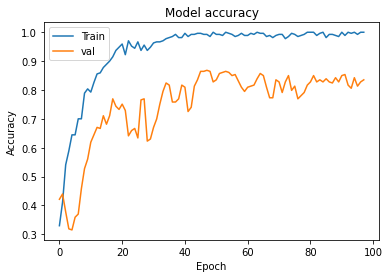

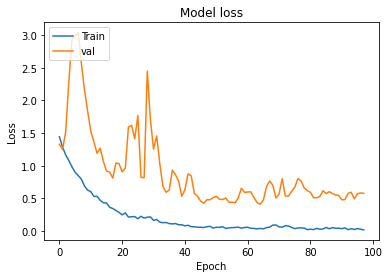


Training on subject  4
Epoch 1/250
5/5 - 16s - loss: 1.4843 - accuracy: 0.1870 - val_loss: 1.3903 - val_accuracy: 0.2939 - 16s/epoch - 3s/step
Epoch 2/250
5/5 - 3s - loss: 1.3337 - accuracy: 0.3626 - val_loss: 1.5987 - val_accuracy: 0.3465 - 3s/epoch - 507ms/step
Epoch 3/250
5/5 - 2s - loss: 1.2846 - accuracy: 0.3855 - val_loss: 2.0485 - val_accuracy: 0.3114 - 2s/epoch - 466ms/step
Epoch 4/250
5/5 - 2s - loss: 1.2492 - accuracy: 0.4313 - val_loss: 2.5645 - val_accuracy: 0.2982 - 2s/epoch - 495ms/step
Epoch 5/250
5/5 - 2s - loss: 1.2057 - accuracy: 0.4466 - val_loss: 2.5782 - val_accuracy: 0.2982 - 2s/epoch - 486ms/step
Epoch 6/250
5/5 - 2s - loss: 1.1735 - accuracy: 0.4695 - val_loss: 2.3694 - val_accuracy: 0.3289 - 2s/epoch - 494ms/step
Epoch 7/250
5/5 - 3s - loss: 1.1179 - accuracy: 0.5267 - val_loss: 2.2955 - val_accuracy: 0.2807 - 3s/epoch - 509ms/step
Epoch 8/250
5/5 - 2s - loss: 1.1039 - accuracy: 0.5344 - val_loss: 2.0429 - val_accuracy: 0.3114 - 2s/epoch - 479ms/step
Epoch 9/2

5/5 - 2s - loss: 0.1419 - accuracy: 0.9695 - val_loss: 1.7231 - val_accuracy: 0.5263 - 2s/epoch - 468ms/step
Epoch 69/250
5/5 - 2s - loss: 0.1187 - accuracy: 0.9809 - val_loss: 1.5128 - val_accuracy: 0.5833 - 2s/epoch - 484ms/step
Epoch 70/250
5/5 - 2s - loss: 0.1222 - accuracy: 0.9809 - val_loss: 1.5296 - val_accuracy: 0.5746 - 2s/epoch - 430ms/step
Epoch 71/250
5/5 - 2s - loss: 0.1251 - accuracy: 0.9771 - val_loss: 1.3171 - val_accuracy: 0.6096 - 2s/epoch - 417ms/step
Epoch 72/250
5/5 - 2s - loss: 0.1012 - accuracy: 0.9847 - val_loss: 1.2202 - val_accuracy: 0.6579 - 2s/epoch - 438ms/step
Epoch 73/250
5/5 - 2s - loss: 0.0909 - accuracy: 0.9924 - val_loss: 1.1473 - val_accuracy: 0.6842 - 2s/epoch - 442ms/step
Epoch 74/250
5/5 - 2s - loss: 0.0957 - accuracy: 0.9847 - val_loss: 1.0590 - val_accuracy: 0.6930 - 2s/epoch - 462ms/step
Epoch 75/250
5/5 - 2s - loss: 0.1132 - accuracy: 0.9695 - val_loss: 1.1331 - val_accuracy: 0.6798 - 2s/epoch - 461ms/step
Epoch 76/250
5/5 - 2s - loss: 0.1212 

Epoch 135/250
5/5 - 2s - loss: 0.0774 - accuracy: 0.9809 - val_loss: 1.0952 - val_accuracy: 0.6711 - 2s/epoch - 426ms/step
Epoch 136/250
5/5 - 2s - loss: 0.0577 - accuracy: 0.9885 - val_loss: 1.0730 - val_accuracy: 0.6711 - 2s/epoch - 462ms/step
Epoch 137/250
5/5 - 2s - loss: 0.0431 - accuracy: 0.9962 - val_loss: 1.1556 - val_accuracy: 0.6447 - 2s/epoch - 443ms/step
Epoch 138/250
5/5 - 2s - loss: 0.0518 - accuracy: 0.9885 - val_loss: 1.2130 - val_accuracy: 0.6447 - 2s/epoch - 466ms/step
Epoch 139/250
5/5 - 2s - loss: 0.0729 - accuracy: 0.9771 - val_loss: 1.1836 - val_accuracy: 0.6623 - 2s/epoch - 493ms/step
Epoch 140/250
5/5 - 2s - loss: 0.0569 - accuracy: 0.9847 - val_loss: 1.1611 - val_accuracy: 0.6711 - 2s/epoch - 451ms/step
Epoch 141/250
5/5 - 2s - loss: 0.0632 - accuracy: 0.9885 - val_loss: 1.1287 - val_accuracy: 0.6798 - 2s/epoch - 443ms/step
Epoch 142/250
5/5 - 2s - loss: 0.0499 - accuracy: 0.9924 - val_loss: 1.1565 - val_accuracy: 0.6272 - 2s/epoch - 455ms/step
Epoch 143/250
5/

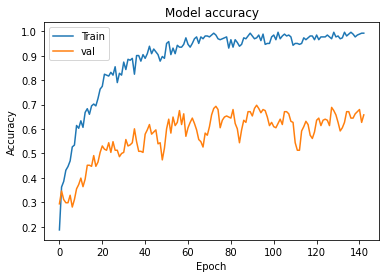

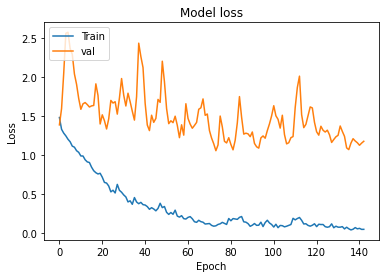


Training on subject  5
Epoch 1/250
5/5 - 15s - loss: 1.4392 - accuracy: 0.2824 - val_loss: 1.3618 - val_accuracy: 0.3152 - 15s/epoch - 3s/step
Epoch 2/250
5/5 - 3s - loss: 1.3302 - accuracy: 0.3702 - val_loss: 1.4867 - val_accuracy: 0.3696 - 3s/epoch - 512ms/step
Epoch 3/250
5/5 - 3s - loss: 1.2335 - accuracy: 0.4695 - val_loss: 1.7461 - val_accuracy: 0.3478 - 3s/epoch - 519ms/step
Epoch 4/250
5/5 - 3s - loss: 1.1960 - accuracy: 0.5229 - val_loss: 1.7652 - val_accuracy: 0.3551 - 3s/epoch - 543ms/step
Epoch 5/250
5/5 - 3s - loss: 1.1295 - accuracy: 0.5573 - val_loss: 1.8634 - val_accuracy: 0.3768 - 3s/epoch - 528ms/step
Epoch 6/250
5/5 - 3s - loss: 1.0764 - accuracy: 0.5687 - val_loss: 1.7674 - val_accuracy: 0.4239 - 3s/epoch - 502ms/step
Epoch 7/250
5/5 - 2s - loss: 1.0166 - accuracy: 0.6183 - val_loss: 1.7777 - val_accuracy: 0.4384 - 2s/epoch - 487ms/step
Epoch 8/250
5/5 - 3s - loss: 0.9853 - accuracy: 0.6260 - val_loss: 1.6795 - val_accuracy: 0.4746 - 3s/epoch - 579ms/step
Epoch 9/2

5/5 - 2s - loss: 0.1909 - accuracy: 0.9466 - val_loss: 1.3273 - val_accuracy: 0.6449 - 2s/epoch - 488ms/step
Epoch 69/250
5/5 - 3s - loss: 0.2195 - accuracy: 0.9275 - val_loss: 1.1128 - val_accuracy: 0.6739 - 3s/epoch - 522ms/step
Epoch 70/250
5/5 - 2s - loss: 0.1539 - accuracy: 0.9695 - val_loss: 1.1072 - val_accuracy: 0.6775 - 2s/epoch - 466ms/step
Epoch 71/250
5/5 - 3s - loss: 0.1388 - accuracy: 0.9618 - val_loss: 1.0667 - val_accuracy: 0.6920 - 3s/epoch - 514ms/step
Epoch 72/250
5/5 - 3s - loss: 0.1658 - accuracy: 0.9504 - val_loss: 1.0462 - val_accuracy: 0.7246 - 3s/epoch - 576ms/step
Epoch 73/250
5/5 - 2s - loss: 0.1287 - accuracy: 0.9695 - val_loss: 1.0108 - val_accuracy: 0.7174 - 2s/epoch - 436ms/step
Epoch 74/250
5/5 - 2s - loss: 0.0789 - accuracy: 0.9885 - val_loss: 1.0210 - val_accuracy: 0.7283 - 2s/epoch - 447ms/step
Epoch 75/250
5/5 - 2s - loss: 0.0934 - accuracy: 0.9809 - val_loss: 1.0297 - val_accuracy: 0.7355 - 2s/epoch - 477ms/step
Epoch 76/250
5/5 - 2s - loss: 0.0709 

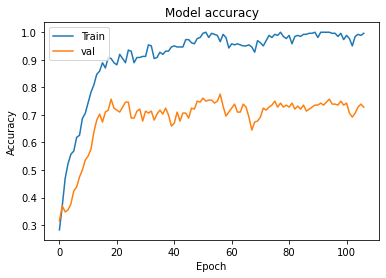

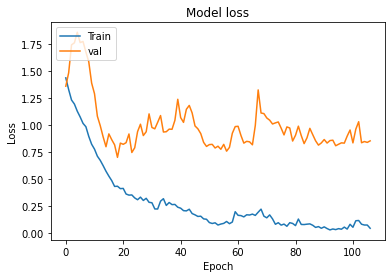


Training on subject  6
Epoch 1/250
4/4 - 12s - loss: 1.5692 - accuracy: 0.2603 - val_loss: 1.3674 - val_accuracy: 0.3302 - 12s/epoch - 3s/step
Epoch 2/250
4/4 - 2s - loss: 1.3368 - accuracy: 0.3014 - val_loss: 1.3266 - val_accuracy: 0.4279 - 2s/epoch - 517ms/step
Epoch 3/250
4/4 - 2s - loss: 1.2807 - accuracy: 0.4795 - val_loss: 1.3205 - val_accuracy: 0.4000 - 2s/epoch - 499ms/step
Epoch 4/250
4/4 - 2s - loss: 1.2140 - accuracy: 0.5205 - val_loss: 1.4336 - val_accuracy: 0.3907 - 2s/epoch - 581ms/step
Epoch 5/250
4/4 - 2s - loss: 1.1401 - accuracy: 0.5616 - val_loss: 1.6220 - val_accuracy: 0.4140 - 2s/epoch - 544ms/step
Epoch 6/250
4/4 - 2s - loss: 1.0697 - accuracy: 0.5845 - val_loss: 1.7204 - val_accuracy: 0.4233 - 2s/epoch - 546ms/step
Epoch 7/250
4/4 - 2s - loss: 0.9868 - accuracy: 0.6712 - val_loss: 1.6917 - val_accuracy: 0.4093 - 2s/epoch - 471ms/step
Epoch 8/250
4/4 - 2s - loss: 0.9269 - accuracy: 0.6895 - val_loss: 1.9117 - val_accuracy: 0.4140 - 2s/epoch - 461ms/step
Epoch 9/2

4/4 - 2s - loss: 0.0409 - accuracy: 0.9954 - val_loss: 1.8473 - val_accuracy: 0.5488 - 2s/epoch - 469ms/step
Epoch 69/250
4/4 - 2s - loss: 0.0370 - accuracy: 0.9954 - val_loss: 1.7926 - val_accuracy: 0.5860 - 2s/epoch - 515ms/step
Epoch 70/250
4/4 - 2s - loss: 0.0309 - accuracy: 1.0000 - val_loss: 1.7028 - val_accuracy: 0.5628 - 2s/epoch - 472ms/step
Epoch 71/250
4/4 - 2s - loss: 0.0326 - accuracy: 1.0000 - val_loss: 1.6357 - val_accuracy: 0.5907 - 2s/epoch - 473ms/step
Epoch 72/250
4/4 - 2s - loss: 0.0348 - accuracy: 0.9909 - val_loss: 1.5881 - val_accuracy: 0.6000 - 2s/epoch - 504ms/step
Epoch 73/250
4/4 - 2s - loss: 0.0314 - accuracy: 1.0000 - val_loss: 1.6329 - val_accuracy: 0.5721 - 2s/epoch - 505ms/step
Epoch 74/250
4/4 - 2s - loss: 0.0390 - accuracy: 1.0000 - val_loss: 1.6246 - val_accuracy: 0.5674 - 2s/epoch - 514ms/step
Epoch 75/250
4/4 - 2s - loss: 0.0464 - accuracy: 0.9909 - val_loss: 1.5984 - val_accuracy: 0.5721 - 2s/epoch - 516ms/step
Epoch 76/250
4/4 - 2s - loss: 0.0306 

Epoch 135/250
4/4 - 2s - loss: 0.0299 - accuracy: 0.9954 - val_loss: 1.4127 - val_accuracy: 0.6093 - 2s/epoch - 486ms/step
Epoch 136/250
4/4 - 2s - loss: 0.0287 - accuracy: 0.9954 - val_loss: 1.4867 - val_accuracy: 0.5953 - 2s/epoch - 532ms/step
Epoch 137/250
4/4 - 2s - loss: 0.0186 - accuracy: 1.0000 - val_loss: 1.5649 - val_accuracy: 0.5814 - 2s/epoch - 474ms/step
Epoch 138/250
4/4 - 2s - loss: 0.0294 - accuracy: 0.9909 - val_loss: 1.5591 - val_accuracy: 0.6047 - 2s/epoch - 525ms/step
Epoch 139/250
4/4 - 2s - loss: 0.0384 - accuracy: 0.9909 - val_loss: 1.4908 - val_accuracy: 0.5767 - 2s/epoch - 505ms/step
Epoch 140/250
4/4 - 2s - loss: 0.0390 - accuracy: 0.9909 - val_loss: 1.4013 - val_accuracy: 0.5907 - 2s/epoch - 523ms/step
Epoch 141/250
4/4 - 2s - loss: 0.0306 - accuracy: 0.9954 - val_loss: 1.5943 - val_accuracy: 0.5860 - 2s/epoch - 482ms/step
Epoch 142/250
4/4 - 2s - loss: 0.0219 - accuracy: 1.0000 - val_loss: 1.7563 - val_accuracy: 0.5488 - 2s/epoch - 456ms/step
Epoch 143/250
4/

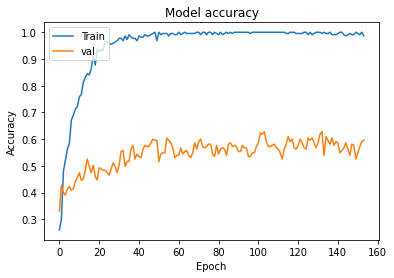

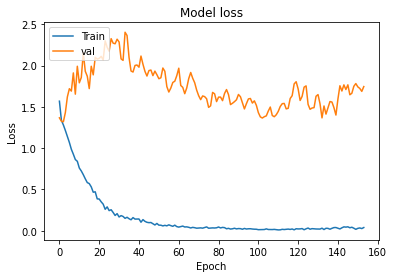


Training on subject  7
Epoch 1/250
5/5 - 12s - loss: 1.4658 - accuracy: 0.2804 - val_loss: 1.3291 - val_accuracy: 0.2744 - 12s/epoch - 2s/step
Epoch 2/250
5/5 - 2s - loss: 1.2228 - accuracy: 0.4613 - val_loss: 1.7049 - val_accuracy: 0.3249 - 2s/epoch - 488ms/step
Epoch 3/250
5/5 - 3s - loss: 1.0953 - accuracy: 0.5646 - val_loss: 2.3893 - val_accuracy: 0.3213 - 3s/epoch - 537ms/step
Epoch 4/250
5/5 - 2s - loss: 0.9435 - accuracy: 0.6900 - val_loss: 2.5027 - val_accuracy: 0.3177 - 2s/epoch - 466ms/step
Epoch 5/250
5/5 - 3s - loss: 0.8494 - accuracy: 0.7491 - val_loss: 2.7693 - val_accuracy: 0.3466 - 3s/epoch - 514ms/step
Epoch 6/250
5/5 - 3s - loss: 0.7621 - accuracy: 0.7897 - val_loss: 2.7450 - val_accuracy: 0.3863 - 3s/epoch - 544ms/step
Epoch 7/250
5/5 - 3s - loss: 0.6690 - accuracy: 0.7934 - val_loss: 2.4020 - val_accuracy: 0.4693 - 3s/epoch - 557ms/step
Epoch 8/250
5/5 - 3s - loss: 0.6193 - accuracy: 0.8303 - val_loss: 2.2709 - val_accuracy: 0.4838 - 3s/epoch - 566ms/step
Epoch 9/2

5/5 - 2s - loss: 0.0320 - accuracy: 0.9963 - val_loss: 0.8182 - val_accuracy: 0.7617 - 2s/epoch - 495ms/step
Epoch 69/250
5/5 - 2s - loss: 0.0448 - accuracy: 0.9889 - val_loss: 0.7318 - val_accuracy: 0.7726 - 2s/epoch - 484ms/step
Epoch 70/250
5/5 - 2s - loss: 0.0266 - accuracy: 0.9963 - val_loss: 0.7696 - val_accuracy: 0.7545 - 2s/epoch - 458ms/step
Epoch 71/250
5/5 - 3s - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.8010 - val_accuracy: 0.7509 - 3s/epoch - 503ms/step
Epoch 72/250
5/5 - 3s - loss: 0.0417 - accuracy: 0.9963 - val_loss: 0.8636 - val_accuracy: 0.7581 - 3s/epoch - 547ms/step
Epoch 73/250
5/5 - 2s - loss: 0.0333 - accuracy: 0.9963 - val_loss: 0.8660 - val_accuracy: 0.7509 - 2s/epoch - 482ms/step
Epoch 74/250
5/5 - 2s - loss: 0.0281 - accuracy: 0.9963 - val_loss: 0.8149 - val_accuracy: 0.7401 - 2s/epoch - 477ms/step
Epoch 75/250
5/5 - 2s - loss: 0.0483 - accuracy: 0.9889 - val_loss: 0.8909 - val_accuracy: 0.7365 - 2s/epoch - 451ms/step
Epoch 76/250
5/5 - 2s - loss: 0.0461 

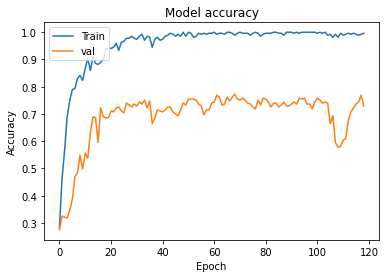

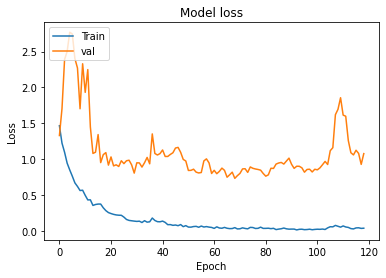


Training on subject  8
Epoch 1/250
5/5 - 12s - loss: 1.5155 - accuracy: 0.2917 - val_loss: 1.3561 - val_accuracy: 0.3321 - 12s/epoch - 2s/step
Epoch 2/250
5/5 - 2s - loss: 1.2827 - accuracy: 0.4205 - val_loss: 1.3737 - val_accuracy: 0.3690 - 2s/epoch - 480ms/step
Epoch 3/250
5/5 - 3s - loss: 1.1730 - accuracy: 0.5455 - val_loss: 1.6666 - val_accuracy: 0.4170 - 3s/epoch - 518ms/step
Epoch 4/250
5/5 - 2s - loss: 1.1057 - accuracy: 0.5833 - val_loss: 2.0573 - val_accuracy: 0.4244 - 2s/epoch - 431ms/step
Epoch 5/250
5/5 - 3s - loss: 1.0293 - accuracy: 0.5985 - val_loss: 2.3426 - val_accuracy: 0.4022 - 3s/epoch - 530ms/step
Epoch 6/250
5/5 - 3s - loss: 0.9575 - accuracy: 0.6553 - val_loss: 2.6529 - val_accuracy: 0.4096 - 3s/epoch - 525ms/step
Epoch 7/250
5/5 - 2s - loss: 0.8925 - accuracy: 0.6477 - val_loss: 2.3850 - val_accuracy: 0.4576 - 2s/epoch - 464ms/step
Epoch 8/250
5/5 - 3s - loss: 0.8570 - accuracy: 0.6856 - val_loss: 2.3232 - val_accuracy: 0.4834 - 3s/epoch - 502ms/step
Epoch 9/2

5/5 - 2s - loss: 0.0742 - accuracy: 0.9886 - val_loss: 0.8349 - val_accuracy: 0.7638 - 2s/epoch - 493ms/step
Epoch 69/250
5/5 - 2s - loss: 0.0639 - accuracy: 0.9924 - val_loss: 0.7568 - val_accuracy: 0.7675 - 2s/epoch - 441ms/step
Epoch 70/250
5/5 - 2s - loss: 0.0563 - accuracy: 0.9962 - val_loss: 0.7905 - val_accuracy: 0.7601 - 2s/epoch - 449ms/step
Epoch 71/250
5/5 - 3s - loss: 0.0454 - accuracy: 0.9962 - val_loss: 0.7252 - val_accuracy: 0.7675 - 3s/epoch - 562ms/step
Epoch 72/250
5/5 - 2s - loss: 0.0733 - accuracy: 0.9811 - val_loss: 0.7349 - val_accuracy: 0.7934 - 2s/epoch - 482ms/step
Epoch 73/250
5/5 - 2s - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.6829 - val_accuracy: 0.7934 - 2s/epoch - 481ms/step
Epoch 74/250
5/5 - 2s - loss: 0.0448 - accuracy: 1.0000 - val_loss: 0.6042 - val_accuracy: 0.8007 - 2s/epoch - 474ms/step
Epoch 75/250
5/5 - 2s - loss: 0.0476 - accuracy: 0.9924 - val_loss: 0.6208 - val_accuracy: 0.8044 - 2s/epoch - 497ms/step
Epoch 76/250
5/5 - 2s - loss: 0.0547 

Epoch 134: early stopping
9/9 [==============================] - 1s 63ms/step
Subject: 8   Train no. 1   Time: 5.6 m   Test_acc: 0.8081   Test_kappa: 0.7442
----------
Subject: 8   best_run: 1   Time: 5.6 m   acc: 0.8081   avg_acc: 0.8081 +- 0.0000   kappa: 0.7442   avg_kappa: 0.7442 +- 0.0000
----------
Plot Learning Curves ....... 


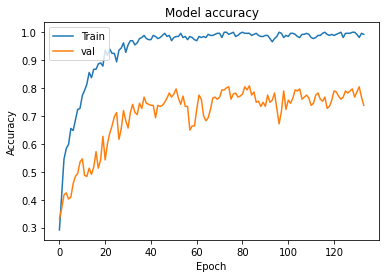

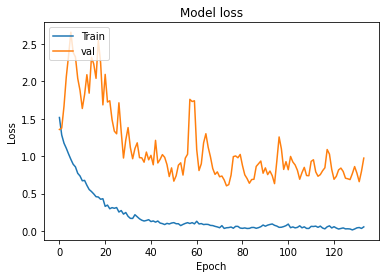


Training on subject  9
Epoch 1/250
4/4 - 13s - loss: 1.4867 - accuracy: 0.2827 - val_loss: 1.3780 - val_accuracy: 0.3068 - 13s/epoch - 3s/step
Epoch 2/250
4/4 - 2s - loss: 1.3058 - accuracy: 0.4219 - val_loss: 1.3804 - val_accuracy: 0.2841 - 2s/epoch - 545ms/step
Epoch 3/250
4/4 - 2s - loss: 1.1656 - accuracy: 0.5992 - val_loss: 1.4629 - val_accuracy: 0.2917 - 2s/epoch - 565ms/step
Epoch 4/250
4/4 - 2s - loss: 1.0511 - accuracy: 0.6582 - val_loss: 2.1003 - val_accuracy: 0.2652 - 2s/epoch - 562ms/step
Epoch 5/250
4/4 - 2s - loss: 0.9077 - accuracy: 0.7637 - val_loss: 3.5084 - val_accuracy: 0.2500 - 2s/epoch - 550ms/step
Epoch 6/250
4/4 - 2s - loss: 0.8421 - accuracy: 0.7384 - val_loss: 4.2379 - val_accuracy: 0.2614 - 2s/epoch - 536ms/step
Epoch 7/250
4/4 - 2s - loss: 0.7439 - accuracy: 0.7722 - val_loss: 4.2863 - val_accuracy: 0.2917 - 2s/epoch - 521ms/step
Epoch 8/250
4/4 - 2s - loss: 0.6404 - accuracy: 0.8312 - val_loss: 3.3462 - val_accuracy: 0.3636 - 2s/epoch - 606ms/step
Epoch 9/2

4/4 - 2s - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.7990 - val_accuracy: 0.7386 - 2s/epoch - 541ms/step
Epoch 69/250
4/4 - 2s - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.7696 - val_accuracy: 0.7614 - 2s/epoch - 531ms/step
Epoch 70/250
4/4 - 2s - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.8170 - val_accuracy: 0.7614 - 2s/epoch - 593ms/step
Epoch 71/250
4/4 - 2s - loss: 0.0194 - accuracy: 0.9958 - val_loss: 0.8628 - val_accuracy: 0.7462 - 2s/epoch - 569ms/step
Epoch 72/250
4/4 - 2s - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.8621 - val_accuracy: 0.7462 - 2s/epoch - 566ms/step
Epoch 73/250
4/4 - 2s - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.8331 - val_accuracy: 0.7538 - 2s/epoch - 533ms/step
Epoch 74/250
4/4 - 2s - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.8178 - val_accuracy: 0.7500 - 2s/epoch - 507ms/step
Epoch 75/250
4/4 - 2s - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.8482 - val_accuracy: 0.7424 - 2s/epoch - 541ms/step
Epoch 76/250
4/4 - 2s - loss: 0.0194 

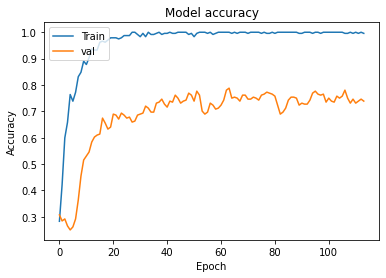

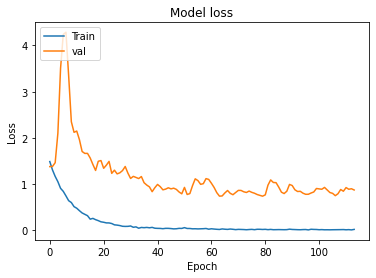


Time: 0.8 h   


In [17]:
data_path = 'C:/Users/Sahil Dhiman/OneDrive/Documents/majpro/BCI-Competition-vi/BCI Competition IV-2a(mat files)/'
    
# Create a folder to store the results of the experiment
results_path = "C:/Users/Sahil Dhiman/OneDrive/Documents/majpro/BCI-Competition-vi/results1"

# Set dataset paramters 
dataset_conf = { 'n_classes': 4, 'n_sub': 9, 'n_channels': 22, 'data_path': data_path,
            'isStandard': True, 'LOSO': False}
# Set training hyperparamters
train_conf = { 'batch_size': 64, 'epochs': 250, 'patience': 50, 'lr': 0.009,
              'LearnCurves': True, 'n_train': 1}

# Train the model
train(dataset_conf, train_conf, results_path)

In [19]:
model=ML_Model()

9/9 [==============================] - 2s 64ms/step


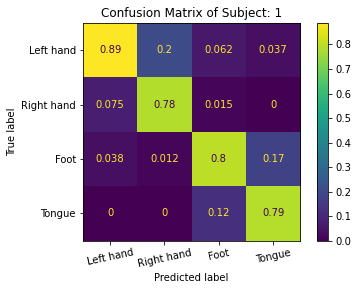

Subject: 1   best_run: 1   acc: 0.8078   kappa: 0.7438   avg_acc: 0.8078 +- 0.0000   avg_kappa: 0.7438 +- 0.0000
9/9 [==============================] - 1s 74ms/step


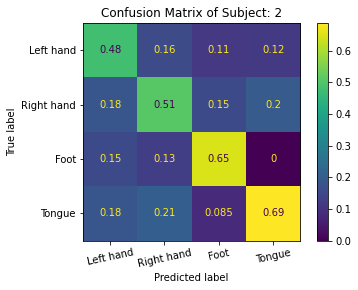

Subject: 2   best_run: 1   acc: 0.5654   kappa: 0.4207   avg_acc: 0.5654 +- 0.0000   avg_kappa: 0.4207 +- 0.0000
9/9 [==============================] - 1s 70ms/step


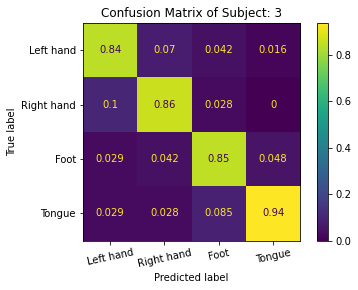

Subject: 3   best_run: 1   acc: 0.8681   kappa: 0.8242   avg_acc: 0.8681 +- 0.0000   avg_kappa: 0.8242 +- 0.0000
8/8 [==============================] - 1s 58ms/step


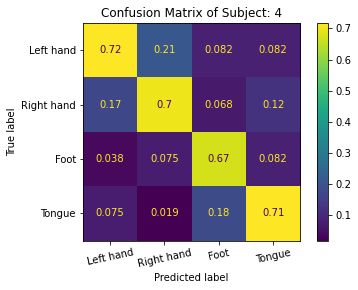

Subject: 4   best_run: 1   acc: 0.6974   kappa: 0.5959   avg_acc: 0.6974 +- 0.0000   avg_kappa: 0.5959 +- 0.0000
9/9 [==============================] - 1s 61ms/step


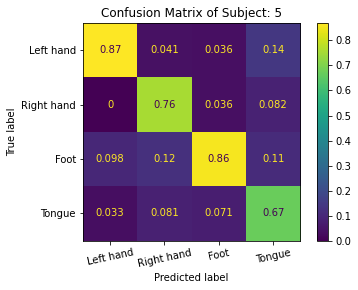

Subject: 5   best_run: 1   acc: 0.7754   kappa: 0.7008   avg_acc: 0.7754 +- 0.0000   avg_kappa: 0.7008 +- 0.0000
7/7 [==============================] - 0s 65ms/step


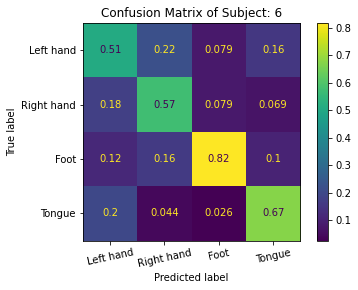

Subject: 6   best_run: 1   acc: 0.6279   kappa: 0.5037   avg_acc: 0.6279 +- 0.0000   avg_kappa: 0.5037 +- 0.0000
9/9 [==============================] - 1s 67ms/step


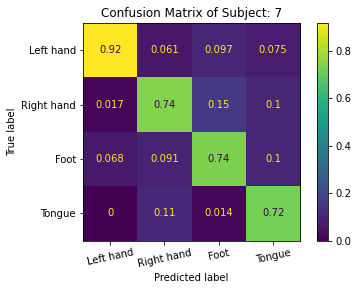

Subject: 7   best_run: 1   acc: 0.7726   kappa: 0.6970   avg_acc: 0.7726 +- 0.0000   avg_kappa: 0.6970 +- 0.0000
9/9 [==============================] - 1s 63ms/step


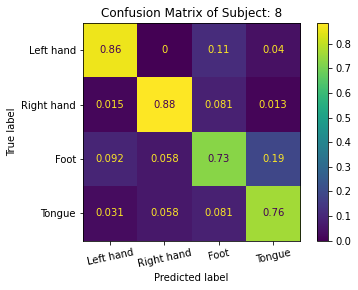

Subject: 8   best_run: 1   acc: 0.8081   kappa: 0.7442   avg_acc: 0.8081 +- 0.0000   avg_kappa: 0.7442 +- 0.0000
9/9 [==============================] - 1s 55ms/step


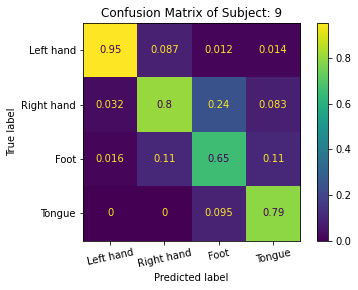

Subject: 9   best_run: 1   acc: 0.7879   kappa: 0.7168   avg_acc: 0.7879 +- 0.0000   avg_kappa: 0.7168 +- 0.0000

Average of 9 subjects - best runs:
Accuracy = 0.7456   Kappa = 0.6608

Average of 9 subjects x 1 runs (average of 9 experiments):
Accuracy = 0.7456   Kappa = 0.6608


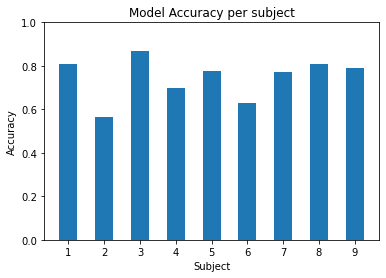

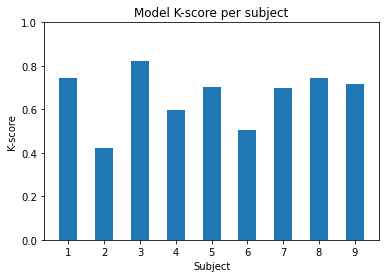

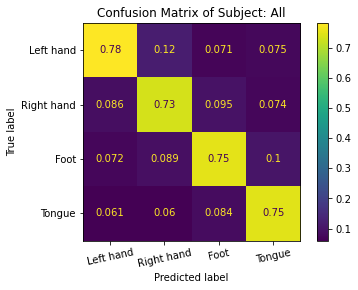

In [22]:
test(model,dataset_conf, results_path)